In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers, callbacks

In [ ]:
print(tf.__version__)

2.17.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
for root, dirs, files in os.walk("/content/drive/My Drive/Colab Notebooks/Project_601/Audio_Files/New/"):
    print(f"Directory: {root}, Number of files: {len(files)}")

Directory: /content/drive/My Drive/Colab Notebooks/Project_601/Audio_Files/New/, Number of files: 0
Directory: /content/drive/My Drive/Colab Notebooks/Project_601/Audio_Files/New/Major_Images, Number of files: 502
Directory: /content/drive/My Drive/Colab Notebooks/Project_601/Audio_Files/New/Minor_Images, Number of files: 357


In [ ]:
!mkdir -p /content/dataset
!cp -r "/content/drive/My Drive/Colab Notebooks/Audio_Files/New/" /content/dataset

^C


In [ ]:
import os

train_path = "/content/dataset/New/"
for root, dirs, files in os.walk(train_path):
    print(f"Directory: {root}, Number of files: {len(files)}")

Directory: /content/dataset/New/, Number of files: 0
Directory: /content/dataset/New/Minor_Images, Number of files: 357
Directory: /content/dataset/New/Major_Images, Number of files: 502


In [ ]:
image_size = (224, 224)  # ResNet requires 224x224
batch_size = 16

# Augmentation and rescaling
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values to [0, 1]
    validation_split=0.2,  # Split data into training and validation
    #rotation_range=15,  # Data augmentation
    width_shift_range=0.1,
    #height_shift_range=0.1,
    #zoom_range=0.1,
    #horizontal_flip=True,
)

# Load training data
train_generator = train_datagen.flow_from_directory(
    "/content/drive/My Drive/Colab Notebooks/Project_601/Audio_Files/New/",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",
    subset="training",
    color_mode="grayscale",  # Load grayscale images
)

# Load validation data
validation_generator = train_datagen.flow_from_directory(
    "/content/drive/My Drive/Colab Notebooks/Project_601/Audio_Files/New/",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",
    subset="validation",
    color_mode="grayscale",
)

Found 688 images belonging to 2 classes.
Found 171 images belonging to 2 classes.


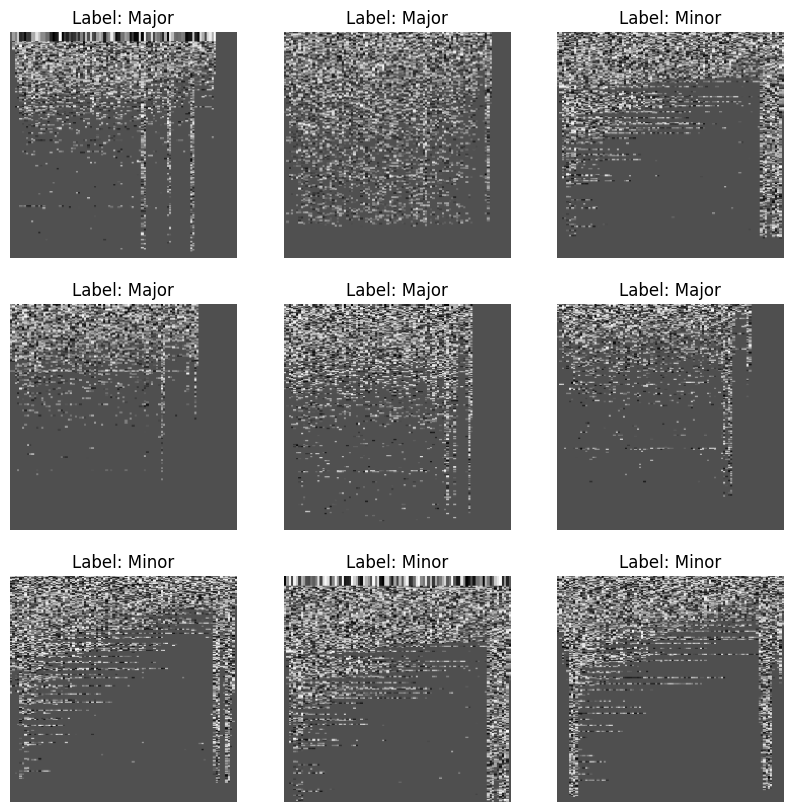

In [ ]:
for batch in train_generator:
    plt.figure(figsize=(10, 10))
    for i in range(9):
        img = batch[0][i]
        label = batch[1][i]
        plt.subplot(3, 3, i + 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f"Label: {'Major' if label == 0 else 'Minor'}")
        plt.axis('off')
    plt.show()
    break

In [ ]:

# Load pre-trained ResNet50 without the top classification layer
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers to retain pre-trained weights
base_model.trainable = False

# Build the full model
model = models.Sequential([
    layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x)),  # Convert grayscale to RGB
    base_model,  # Add the ResNet base model
    layers.GlobalAveragePooling2D(),  # Reduce feature maps to a single vector
    layers.Dense(128, activation="relu"),  # Add a dense layer
    layers.Dropout(0.5),  # Add dropout for regularization
    layers.Dense(1, activation="sigmoid")  # Output layer for binary classification
])

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# Model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_3 (Lambda)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Callbacks
best_model_file = "/content/drive/My Drive/Colab Notebooks/Project_601/Audio_Files/best_resnet_model.keras"
best_model = callbacks.ModelCheckpoint(
    best_model_file, monitor="val_accuracy", verbose=1, save_best_only=True
)
early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Train only the custom layers
history = model.fit(
    train_generator,
    #steps_per_epoch=len(train_generator),
    epochs=10,  # Start with fewer epochs
    validation_data=validation_generator,
    #validation_steps=len(validation_generator),
    callbacks=[best_model, early_stopping],
    verbose=1
)

Epoch 1/10
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5249 - loss: 0.7754
Epoch 1: val_accuracy improved from -inf to 0.41520, saving model to /content/drive/My Drive/Colab Notebooks/Project_601/Audio_Files/best_resnet_model.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 239ms/step - accuracy: 0.5262 - loss: 0.7747 - val_accuracy: 0.4152 - val_loss: 0.7642
Epoch 2/10
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.4968 - loss: 0.7474
Epoch 2: val_accuracy improved from 0.41520 to 0.58480, saving model to /content/drive/My Drive/Colab Notebooks/Project_601/Audio_Files/best_resnet_model.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.4980 - loss: 0.7458 - val_accuracy: 0.5848 - val_loss: 0.6789
Epoch 3/10
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5459 - loss: 0.6895
Epoch 3: val_accuracy did not improve from 0.58480
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.5478 - loss: 0.6892 - val_accuracy: 0.5848 - val_loss: 0.6796
Epoch 4/10
41/43 ━━━━━━━━

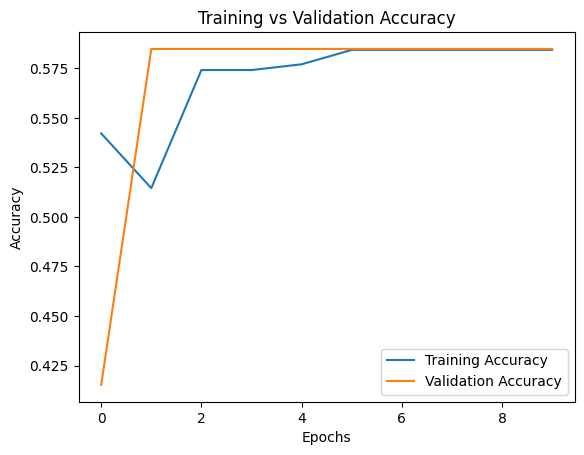

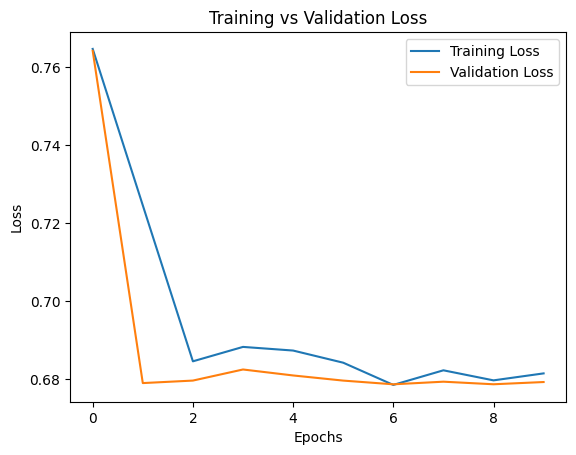

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()